In [1]:
# Imports
from utils.analysis.tools import simDir
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from utils.plot import _FIGURE_DIR, get_size_inches, _CM

In [2]:
root = (Path("/nfs/arupclab001/davidgoh/")
    / "CoupledEPCondensates/workspace/"
    / "01_Flow/20231120_FlowPhaseDiagramHighRes")

In [3]:
sweep_directory = Path(root)
sweep_file = sweep_directory / "sweep_parameters.txt"
sweep_parameters = [line.split(",")[0] for line in sweep_file.read_text().splitlines()]

In [4]:
simdir_paths = [file.parent for file in sweep_directory.glob("./*/input_params.txt")]

In [5]:
col = sweep_parameters + ["n_condensate", "max_eccentricity", "max_variance", "mean"]

In [6]:
def worker(worker_input):
    simdir_path = worker_input
    sd = simDir(simdir_path)
    val = []
    sd.run()
    sd.condensate()
    val.append(sd.params['k_production'])
    val.append(sd.params['initial_values'][0])
    
    try:
        val.append(sd.n_condensate().max())
    except:
        val.append(0)

    if val[2] == 1:
        val.append(sd.eccentricity.max())
        val.append(np.var(sd.radius,axis=1).max())
        val.append(np.mean(sd.radius))
    else:
        val += [np.nan, np.nan, np.nan]
    
    return val

In [ ]:
simdir_paths = [file.parent for file in sweep_directory.glob("./*/input_params.txt")]
processes = mp.Pool(8-1)
results = processes.map(worker,simdir_paths)

In [ ]:
df = pd.DataFrame(results)
df.columns = col
pivot = df.pivot_table(index="initial_values",
    columns="k_production",
    values=["max_eccentricity","max_variance","mean", "n_condensate"]
    )

In [9]:
# pivot.to_pickle("20240406_pivot.pkl")
pivot = pd.read_pickle("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/01_Analysis/20240406_pivot.pkl")

In [10]:
pivot = pivot.sort_index()

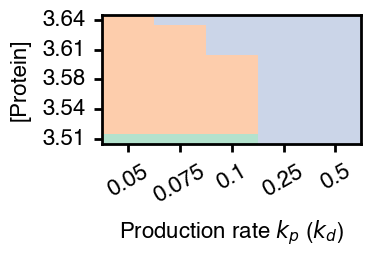

In [11]:
variable = "n_condensate"
cbarlabel = variable
fig, ax = plt.subplots()
fig.set_size_inches(8.5/2*_CM,8.5*_CM/4)
g = sns.heatmap(pivot[variable][pivot[variable].columns[1:]], ax = ax,
                cbar_kws={'label': ""},
                cmap=sns.color_palette([sns.color_palette("Pastel2")[1],
                    sns.color_palette("Pastel2")[2],
                    sns.color_palette("Pastel2")[0]]
                    ),
                vmin=1,vmax=3)
colorbar = ax.collections[0].colorbar 

ax.invert_yaxis()
ax.set_xlabel("Production rate $k_p$ ($k_d$)")
ax.set_ylabel("[Protein]")
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
# ax.yaxis.set_label_coords(-0.25,0.4)
# n = 3
# r = colorbar.vmax - colorbar.vmin 
# colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
# colorbar.set_ticklabels(["Flow", "Nucleation", "Dissolution"],
#                         va="center")
# ax.locator_params(axis='y', nbins=8)
# ax.locator_params(axis='x', nbins=6)
ax.tick_params(axis='x', labelrotation=30)
colorbar.remove()
plt.savefig(_FIGURE_DIR / "Fig1_B_PhaseDiagram")  